In [1]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
#dataset
data = {
    "CustomerID": range(1, 101),
    "Age": np.random.randint(18, 65, 100),
    "Gender": np.random.choice(["Male", "Female"], 100),
    "AnnualIncome": np.random.randint(25000, 120000, 100),
    "SpendingScore": np.random.randint(1, 100, 100),
    "PreviousPurchase": np.random.choice(["Yes", "No"], 100, p=[0.6, 0.4]),
    "Engagement": np.random.choice(["Low", "Medium", "High"], 100, p=[0.2, 0.4, 0.4]),
}
df = pd.DataFrame(data)
prob = (
    0.3*(df["AnnualIncome"] > 60000).astype(int) +
    0.3*(df["SpendingScore"] > 50).astype(int) +
    0.2*(df["PreviousPurchase"] == "Yes").astype(int) +
    0.2*(df["Engagement"] == "High").astype(int)
)
df["Purchase"] = np.where(prob + np.random.normal(0, 0.2, 100) > 0.7, "Yes", "No")
df.to_csv("customer_data.csv", index=False)
df.head()

,CustomerID,Age,Gender,AnnualIncome,SpendingScore,PreviousPurchase,Engagement,Purchase
0,1,24,Male,32240,7,No,Low,No
1,2,18,Female,66053,80,Yes,Low,Yes
2,3,25,Female,37893,2,Yes,Medium,No
3,4,38,Female,58819,23,No,High,No
4,5,45,Male,59576,80,No,Medium,No


In [3]:
#csv
df = pd.read_csv("customer_data.csv")
df.head()

,CustomerID,Age,Gender,AnnualIncome,SpendingScore,PreviousPurchase,Engagement,Purchase
0,1,24,Male,32240,7,No,Low,No
1,2,18,Female,66053,80,Yes,Low,Yes
2,3,25,Female,37893,2,Yes,Medium,No
3,4,38,Female,58819,23,No,High,No
4,5,45,Male,59576,80,No,Medium,No


In [4]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())
print("\nTarget distribution:")
print(df["Purchase"].value_counts())

Shape: (100, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        100 non-null    int64 
 1   Age               100 non-null    int64 
 2   Gender            100 non-null    object
 3   AnnualIncome      100 non-null    int64 
 4   SpendingScore     100 non-null    int64 
 5   PreviousPurchase  100 non-null    object
 6   Engagement        100 non-null    object
 7   Purchase          100 non-null    object
dtypes: int64(4), object(4)
memory usage: 6.4+ KB
None

Missing values per column:
CustomerID          0
Age                 0
Gender              0
AnnualIncome        0
SpendingScore       0
PreviousPurchase    0
Engagement          0
Purchase            0
dtype: int64

Target distribution:
Purchase
No     74
Yes    26
Name: count, dtype: int64


In [5]:
#preprocessing
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])
X = df.drop(columns=["Purchase"])
y = df["Purchase"]
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (80, 6) Test shape: (20, 6)


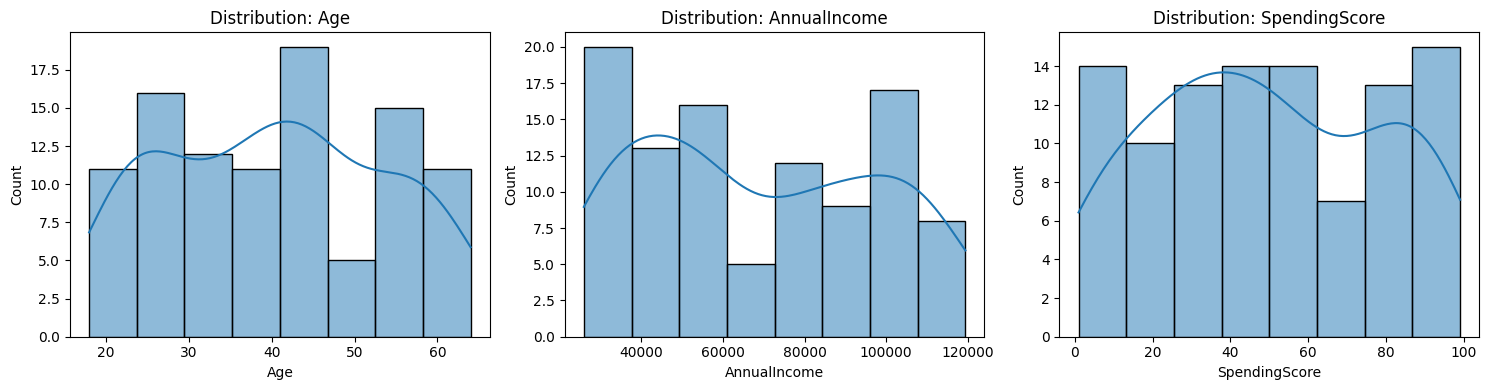

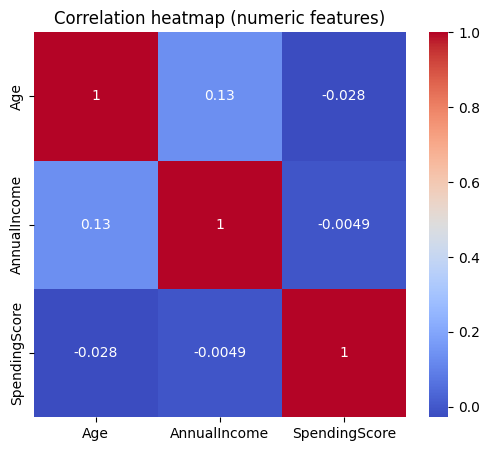

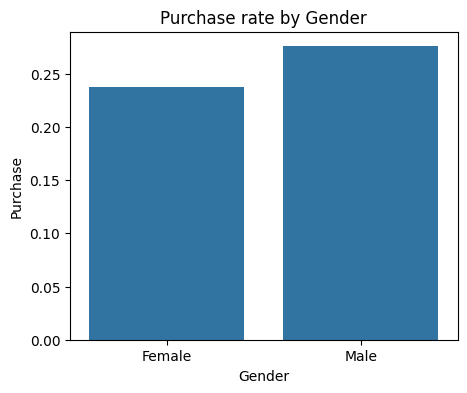

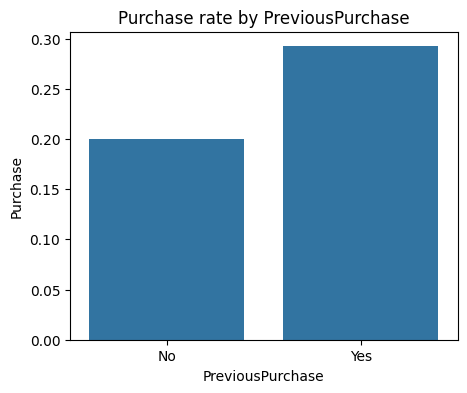

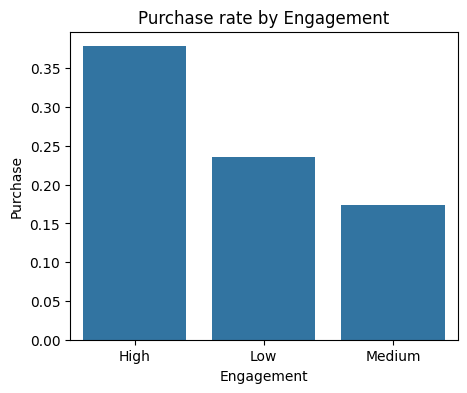

In [6]:
# EDA
fig, axes = plt.subplots(1, len(numeric_features), figsize=(5*len(numeric_features), 4))
if len(numeric_features) == 1:
    axes = [axes]
for ax, col in zip(axes, numeric_features):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
plt.tight_layout()
plt.show()
if len(numeric_features) > 1:
    plt.figure(figsize=(6, 5))
    sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation heatmap (numeric features)")
    plt.show()
for col in categorical_features:
    plt.figure(figsize=(5, 4))
    purchase_rate = df.groupby(col)["Purchase"].apply(lambda x: (x == "Yes").mean()).reset_index()
    sns.barplot(x=col, y="Purchase", data=purchase_rate)
    plt.title(f"Purchase rate by {col}")
    plt.show()


In [7]:
#models
models = {
    "Logistic Regression": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "Random Forest": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    "KNN": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
}


=== Logistic Regression ===
              precision    recall  f1-score   support

          No       0.82      0.93      0.88        15
         Yes       0.67      0.40      0.50         5

    accuracy                           0.80        20
   macro avg       0.75      0.67      0.69        20
weighted avg       0.78      0.80      0.78        20



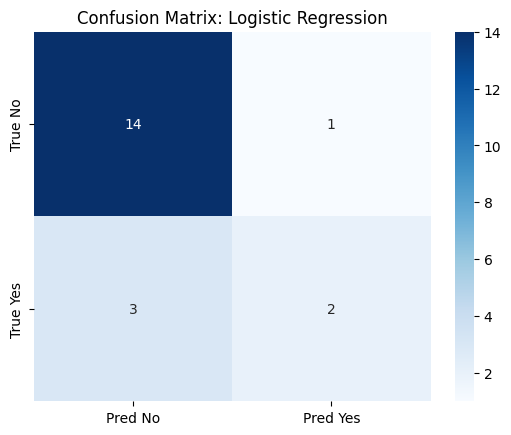


=== Decision Tree ===
              precision    recall  f1-score   support

          No       0.71      0.80      0.75        15
         Yes       0.00      0.00      0.00         5

    accuracy                           0.60        20
   macro avg       0.35      0.40      0.38        20
weighted avg       0.53      0.60      0.56        20



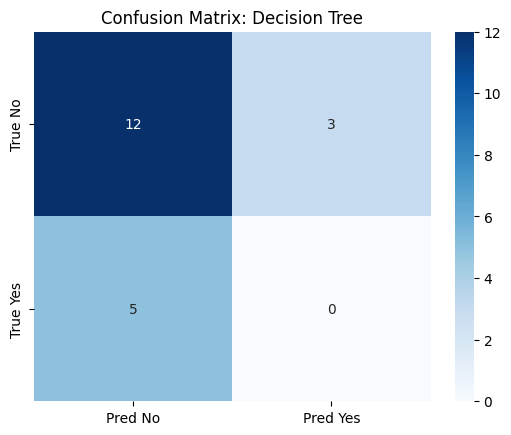


=== Random Forest ===
              precision    recall  f1-score   support

          No       0.81      0.87      0.84        15
         Yes       0.50      0.40      0.44         5

    accuracy                           0.75        20
   macro avg       0.66      0.63      0.64        20
weighted avg       0.73      0.75      0.74        20



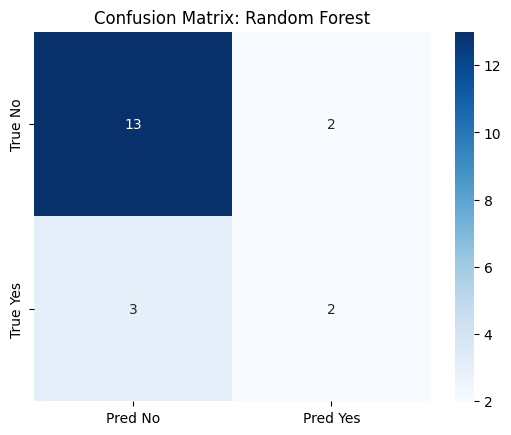


=== KNN ===
              precision    recall  f1-score   support

          No       0.72      0.87      0.79        15
         Yes       0.00      0.00      0.00         5

    accuracy                           0.65        20
   macro avg       0.36      0.43      0.39        20
weighted avg       0.54      0.65      0.59        20



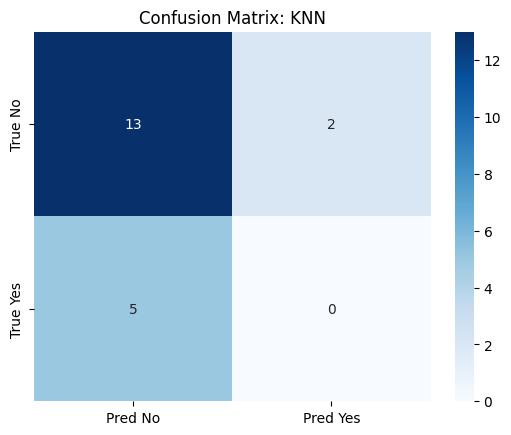

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.80,0.666667,0.4,0.500000
2,Random Forest,0.75,0.500000,0.4,0.444444
1,Decision Tree,0.60,0.000000,0.0,0.000000
3,KNN,0.65,0.000000,0.0,0.000000


In [8]:
#model evaluating
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label="Yes")
    rec = recall_score(y_test, y_pred, pos_label="Yes")
    f1 = f1_score(y_test, y_pred, pos_label="Yes")
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=["No", "Yes"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred No", "Pred Yes"],
                yticklabels=["True No", "True Yes"])
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
pd.DataFrame(results).sort_values(by="F1", ascending=False)


In [9]:
#model comparison
comparison_df = pd.DataFrame(results).round(3).sort_values(by="F1", ascending=False)
print("\nModel comparison:")
display(comparison_df)

best_model_name = comparison_df.iloc[0]["Model"]
print(f"\nBest model by F1: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("\nBest model classification report:")
print(classification_report(y_test, y_pred_best))


Model comparison:


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.80,0.667,0.4,0.500
2,Random Forest,0.75,0.500,0.4,0.444
1,Decision Tree,0.60,0.000,0.0,0.000
3,KNN,0.65,0.000,0.0,0.000



Best model by F1: Logistic Regression

Best model classification report:
              precision    recall  f1-score   support

          No       0.82      0.93      0.88        15
         Yes       0.67      0.40      0.50         5

    accuracy                           0.80        20
   macro avg       0.75      0.67      0.69        20
weighted avg       0.78      0.80      0.78        20

